##Importing necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from numpy import mean
from numpy import std
from sklearn import tree
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import scale, normalize, minmax_scale
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import sklearn.metrics as met
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score

##Loading the data from Kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download "houcembenmansour/predict-diabetes-based-on-diagnostic-measures"

In [ ]:
!unzip predict-diabetes-based-on-diagnostic-measures.zip

In [73]:
df = pd.read_csv("/content/diabetes.csv")
df

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,1,193,77,49,"3,9",19,female,61,119,"22,5",118,70,32,38,"0,84",No diabetes
1,2,146,79,41,"3,6",19,female,60,135,"26,4",108,58,33,40,"0,83",No diabetes
2,3,217,75,54,4,20,female,67,187,"29,3",110,72,40,45,"0,89",No diabetes
3,4,226,97,70,"3,2",20,female,64,114,"19,6",122,64,31,39,"0,79",No diabetes
4,5,164,91,67,"2,4",20,female,70,141,"20,2",122,86,32,39,"0,82",No diabetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,386,227,105,44,"5,2",83,female,59,125,"25,2",150,90,35,40,"0,88",No diabetes
386,387,226,279,52,"4,3",84,female,60,192,"37,5",144,88,41,48,"0,85",Diabetes
387,388,301,90,118,"2,6",89,female,61,115,"21,7",218,90,31,41,"0,76",No diabetes
388,389,232,184,114,2,91,female,61,127,24,170,82,35,38,"0,92",Diabetes


###The dataset contains 390 rows with 15 features, including 60 diabetes patients (15%). In light of this, we need to balance the dataset for better analyses.

In [74]:
df['diabetes'].value_counts(normalize=True)

No diabetes    0.846154
Diabetes       0.153846
Name: diabetes, dtype: float64

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_number   390 non-null    int64 
 1   cholesterol      390 non-null    int64 
 2   glucose          390 non-null    int64 
 3   hdl_chol         390 non-null    int64 
 4   chol_hdl_ratio   390 non-null    object
 5   age              390 non-null    int64 
 6   gender           390 non-null    object
 7   height           390 non-null    int64 
 8   weight           390 non-null    int64 
 9   bmi              390 non-null    object
 10  systolic_bp      390 non-null    int64 
 11  diastolic_bp     390 non-null    int64 
 12  waist            390 non-null    int64 
 13  hip              390 non-null    int64 
 14  waist_hip_ratio  390 non-null    object
 15  diabetes         390 non-null    object
dtypes: int64(11), object(5)
memory usage: 48.9+ KB


###Changing some columns' types


In [76]:
df = df.drop('patient_number', axis=1)

In [77]:
df['chol_hdl_ratio'] = pd.Series(df['chol_hdl_ratio']).str.replace(',','.')
df['bmi'] = pd.Series(df['bmi']).str.replace(',','.')
df['waist_hip_ratio'] = pd.Series(df['waist_hip_ratio']).str.replace(',','.')

In [78]:
df['chol_hdl_ratio'] = pd.to_numeric(df['chol_hdl_ratio'])
df['bmi'] = pd.to_numeric(df['bmi'])
df['waist_hip_ratio'] = pd.to_numeric(df['waist_hip_ratio'])

In [79]:
code = {'female':1,
        'male':0,
        'No diabetes':1,
        'Diabetes':0
        }
for col in df.select_dtypes('object'):
   df.loc[:,col]=df[col].map(code)        

In [80]:
df.describe()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,207.230769,107.338462,50.266667,4.524615,46.774359,0.584615,65.951282,177.407692,28.775641,137.133333,83.289744,37.869231,42.992308,0.881385,0.846154
std,44.666005,53.798188,17.279069,1.736634,16.435911,0.493421,3.918867,40.407824,6.600915,22.859528,13.498192,5.760947,5.664342,0.073212,0.361265
min,78.000000,48.000000,12.000000,1.500000,19.000000,0.000000,52.000000,99.000000,15.200000,90.000000,48.000000,26.000000,30.000000,0.680000,0.000000
25%,179.000000,81.000000,38.000000,3.200000,34.000000,0.000000,63.000000,150.250000,24.100000,122.000000,75.000000,33.000000,39.000000,0.830000,1.000000
50%,203.000000,90.000000,46.000000,4.200000,44.500000,1.000000,66.000000,173.000000,27.800000,136.000000,82.000000,37.000000,42.000000,0.880000,1.000000
75%,229.000000,107.750000,59.000000,5.400000,60.000000,1.000000,69.000000,200.000000,32.275000,148.000000,90.000000,41.000000,46.000000,0.930000,1.000000
max,443.000000,385.000000,120.000000,19.300000,92.000000,1.000000,76.000000,325.000000,55.800000,250.000000,124.000000,56.000000,64.000000,1.140000,1.000000


###Checkind  missing data
####(No invalid data has been found.)

In [81]:
df.isnull().all()

cholesterol        False
glucose            False
hdl_chol           False
chol_hdl_ratio     False
age                False
gender             False
height             False
weight             False
bmi                False
systolic_bp        False
diastolic_bp       False
waist              False
hip                False
waist_hip_ratio    False
diabetes           False
dtype: bool

###Normalization

In [82]:
df_minmax = minmax_scale(df, feature_range=(0,1))
df = pd.DataFrame(df_minmax, index = df.index, columns = df.columns)

###Spliting into train and test sets

In [83]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']
print('X', X.shape)
print('y', y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=1)
# summarize
print('Train', X_train.shape, Y_train.shape)
print('Test', X_test.shape, Y_test.shape)

X (390, 14)
y (390,)
Train (312, 14) (312,)
Test (78, 14) (78,)


###removing outlier

In [84]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_in = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_in

In [85]:
X_train['diabetes'] = Y_train.tolist()
set_of_columns = ['cholesterol', 'glucose',	'hdl_chol',	'chol_hdl_ratio',	'age', 'height',	'weight',	'bmi',	'systolic_bp',	'diastolic_bp',	'waist',	'hip',	'waist_hip_ratio']
for col in set_of_columns:
    X_train=remove_outlier(X_train, col)

###Checking heat map and corrilations
####(There is a significant correlation between the six pairs. The waist and hip have the highest correlation, 0.82.)


<Figure size 432x288 with 0 Axes>

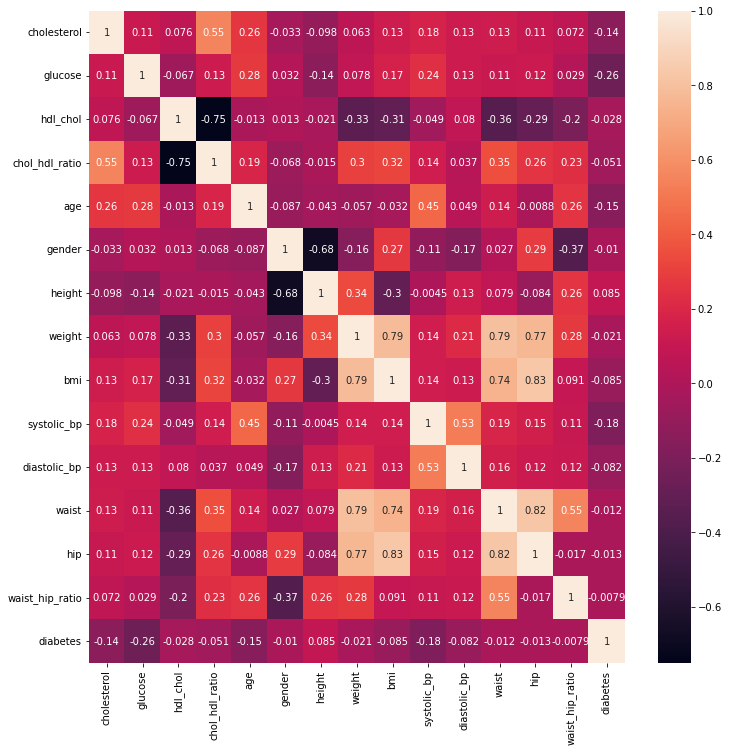

In [86]:
fig = plt.figure()
fig=plt.figure(figsize=(12,12))
sns.heatmap(X_train.corr(),annot=True )
fig.savefig('heat.png')

<Figure size 3200x1200 with 0 Axes>

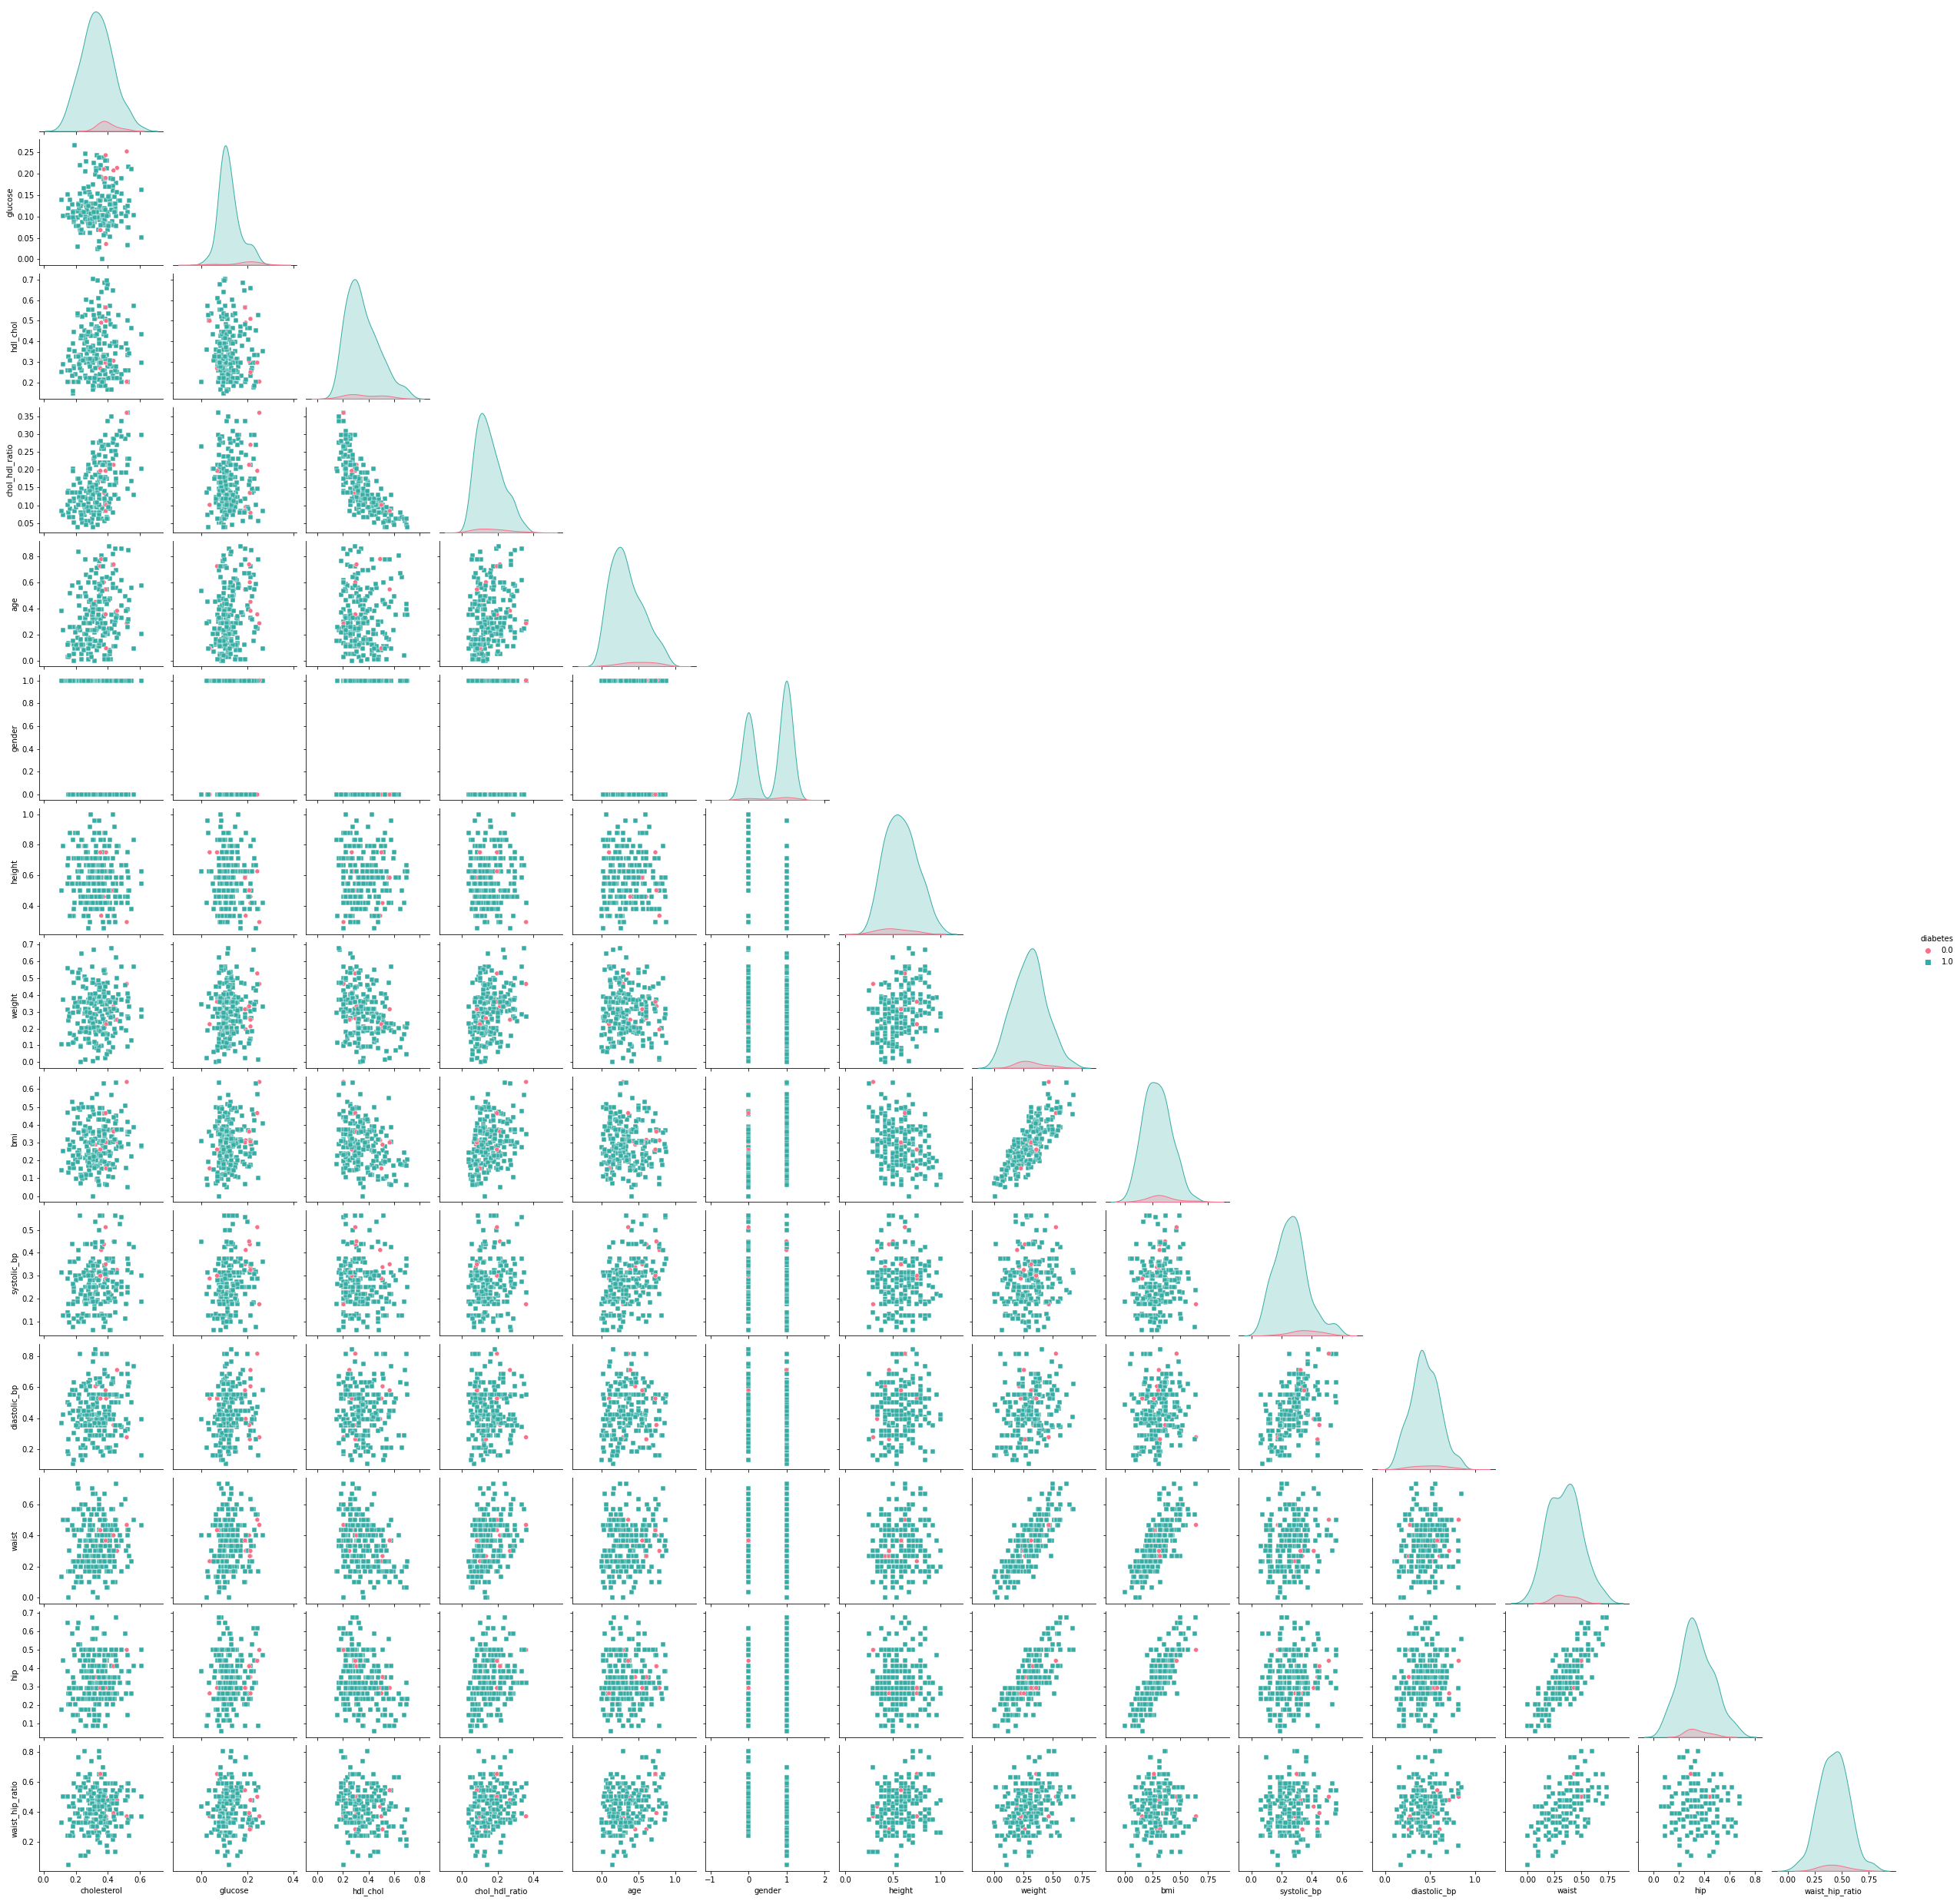

In [87]:
plt.figure(figsize = (16,6),dpi = 200)
sns.pairplot(X_train,hue="diabetes",palette="husl", markers=["o", "s"], corner=True)
plt.savefig('r.png')
plt.show()

###Data balancing

In [88]:
sm = SMOTE(random_state = 2)
x_resampled, y_resampled = sm.fit_resample(X_train.loc[:, X_train.columns != 'diabetes'], X_train['diabetes'].ravel())

In [89]:
sum(y_resampled)/len(y_resampled)*100

50.0

In [90]:
x_resampled

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio
0,0.449315,0.100890,0.388889,0.168539,0.561644,1.000000,0.541667,0.252212,0.266010,0.250000,0.552632,0.433333,0.441176,0.413043
1,0.347945,0.091988,0.185185,0.275281,0.767123,0.000000,0.708333,0.464602,0.366995,0.287500,0.552632,0.600000,0.352941,0.804348
2,0.465753,0.136499,0.527778,0.117978,0.205479,0.000000,0.791667,0.402655,0.278325,0.262500,0.500000,0.333333,0.352941,0.391304
3,0.347945,0.103858,0.277778,0.191011,0.726027,1.000000,0.375000,0.358407,0.463054,0.500000,0.552632,0.433333,0.500000,0.326087
4,0.323288,0.213650,0.509259,0.078652,0.452055,1.000000,0.416667,0.212389,0.288177,0.337500,0.605263,0.266667,0.352941,0.282609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.357853,0.084638,0.308431,0.181494,0.702039,0.000000,0.727549,0.352447,0.266392,0.306735,0.533406,0.424353,0.294118,0.637532
416,0.439408,0.221201,0.261781,0.251079,0.376590,0.745539,0.500744,0.322020,0.346158,0.372711,0.737312,0.350892,0.309611,0.483793
417,0.459766,0.230548,0.308549,0.263104,0.467802,1.000000,0.306886,0.366012,0.520738,0.261751,0.319571,0.405789,0.424798,0.393387
418,0.432775,0.208435,0.310434,0.225943,0.483288,1.000000,0.426954,0.237772,0.307274,0.346966,0.631252,0.300000,0.272089,0.467346


###Feature Selection
1. Xgboost

In [91]:
def model(X_train,y_train,final_test,n_splits=3):
    scores=[]
    pars = {
        'colsample_bytree': 0.8,                 
        'learning_rate': 0.08,
        'max_depth': 10,
        'subsample': 1,
        'objective':'multi:softprob',
        'num_class':4,
        'eval_metric':'mlogloss',
        'min_child_weight':3,
        'gamma':0.25,
        'n_estimators':500
    }

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_pre=np.zeros((len(final_test),4),dtype=float)
    final_test=xgb.DMatrix(final_test.drop('diabetes',axis=1))


    for train_index, val_index in kf.split(X_train, y_train):
        train_X = X_train.iloc[train_index]
        val_X = X_train.iloc[val_index]
        train_y = y_train[train_index]
        val_y = y_train[val_index]
        xgb_train = xgb.DMatrix(train_X, train_y)
        xgb_eval = xgb.DMatrix(val_X, val_y)

        xgb_model = xgb.train(pars,
                      xgb_train,
                      num_boost_round=1000,
                      evals=[(xgb_train, 'train'), (xgb_eval, 'val')],
                      verbose_eval=False,
                      early_stopping_rounds=20
                     )

        val_X=xgb.DMatrix(val_X)
        pred_val=[np.argmax(x) for x in xgb_model.predict(val_X)]
        score=cohen_kappa_score(pred_val,val_y,weights='quadratic')
        scores.append(score)
        print('choen_kappa_score :',score)

        pred=xgb_model.predict(final_test)
        y_pre+=pred

    pred = np.asarray([np.argmax(line) for line in y_pre])
    print('Mean score:',np.mean(scores))
    
    return xgb_model,pred

In [92]:
x_train = x_resampled
x_train['diabetes'] = y_resampled.tolist()
xgb_model,pred=model(x_train.loc[:, x_train.columns != 'diabetes'], x_train['diabetes'] ,x_train,5)

choen_kappa_score : 0.9047619047619048
choen_kappa_score : 0.9761904761904762
choen_kappa_score : 0.9285714285714286
choen_kappa_score : 0.9047619047619048
choen_kappa_score : 0.9523809523809523
Mean score: 0.9333333333333332


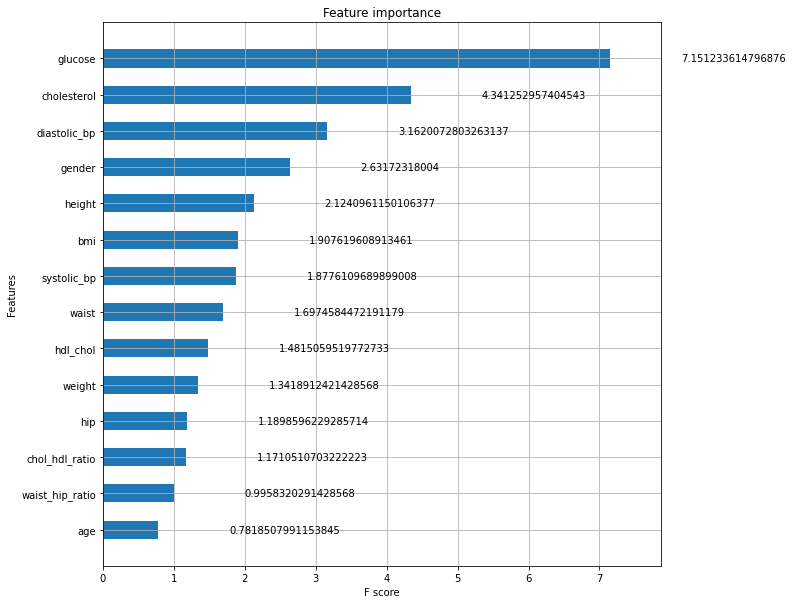

In [93]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.5, ax=ax,importance_type='gain')
plt.show()

2. Random Forest

Feature ranking:
1. feature 1 (0.178955)
2. feature 0 (0.176763)
3. feature 9 (0.128025)
4. feature 12 (0.071813)
5. feature 11 (0.066282)
6. feature 4 (0.061331)
7. feature 8 (0.060007)
8. feature 6 (0.054249)
9. feature 7 (0.044950)
10. feature 10 (0.044863)
11. feature 2 (0.035470)
12. feature 3 (0.032573)
13. feature 13 (0.029170)
14. feature 5 (0.015550)


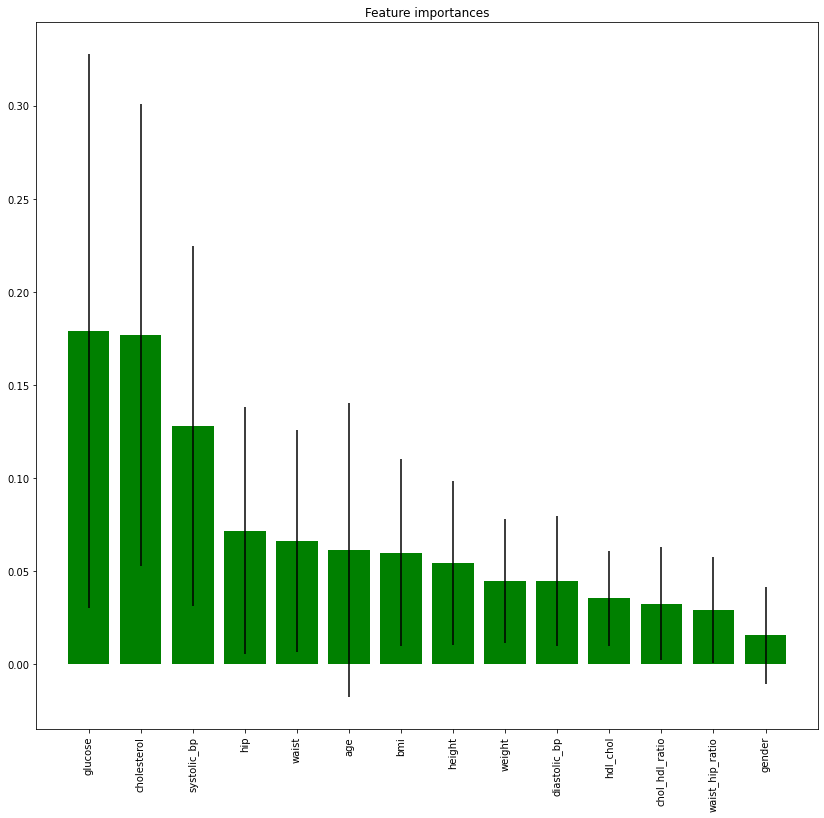

In [94]:
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(x_train.loc[:, x_train.columns != 'diabetes'], x_train['diabetes'])
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_resampled,y_resampled)

importances = clr_rf_2.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.loc[:, x_train.columns != 'diabetes'].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.loc[:, x_train.columns != 'diabetes'].shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.loc[:, x_train.columns != 'diabetes'].shape[1]), x_train.loc[:, x_train.columns != 'diabetes'].columns[indices],rotation=90)
plt.xlim([-1, x_train.loc[:, x_train.columns != 'diabetes'].shape[1]])
plt.show()

3. k highest scores.

In [95]:
fs1 = SelectKBest(score_func=f_classif, k=7)
fs1.fit(x_train.loc[:, x_train.columns != 'diabetes'], x_train['diabetes'])
# transform train data
X_train_fs1 = fs1.transform(x_train.loc[:, x_train.columns != 'diabetes'])
X_test_fs1 = fs1.transform(X_test)

print(x_train.loc[:, x_train.columns != 'diabetes'].columns.values[fs1.get_support()])

# summarize data
print('Train_fs', X_train_fs1.shape)
print('Test_fs', X_test_fs1.shape)



['cholesterol' 'glucose' 'age' 'height' 'bmi' 'systolic_bp' 'diastolic_bp']
Train_fs (420, 7)
Test_fs (78, 7)


4. Decision Tree

In [96]:
model = DecisionTreeClassifier()
rfe = RFE(estimator = model, n_features_to_select = 7)
rfe.fit(x_train.loc[:, x_train.columns != 'diabetes'], x_train['diabetes'])
X_train_rfe = rfe.transform(x_train.loc[:, x_train.columns != 'diabetes'])
X_test_rfe = rfe.transform(X_test)

# summarize selected features
print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)

print(x_train.loc[:, x_train.columns != 'diabetes'].columns.values[rfe.support_])

# summarize data
print('Train_fs', X_train_rfe.shape)
print('Test_fs', X_test_rfe.shape)

Num Features: 7
Selected Features: [ True  True False False  True False  True False  True False  True  True
 False False]
Feature Ranking: [1 1 8 7 1 6 1 5 1 3 1 1 4 2]
['cholesterol' 'glucose' 'age' 'height' 'bmi' 'diastolic_bp' 'waist']
Train_fs (420, 7)
Test_fs (78, 7)


###Data Classification

In [97]:
# KNN
from sklearn.neighbors import KNeighborsClassifier 
 
knn = KNeighborsClassifier(n_neighbors=4, metric='minkowski', p=2) 
knn.fit(X_train_rfe, x_train['diabetes']) 


# Decision Tree
from sklearn.tree import DecisionTreeClassifier 
dtc = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=3, min_samples_leaf=5) 
dtc = dtc.fit(X_train_rfe, x_train['diabetes']) 


# SVM
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf')
svm = svm.fit(X_train_rfe, x_train['diabetes']) 


# Logestic regression
LR = LogisticRegression(solver='liblinear')
LR = LR.fit(X_train_rfe, x_train['diabetes'])


In [98]:
models = []
models.append(('LR', LR))
models.append(('KNN', knn))
models.append(('DTC', dtc))
models.append(('SVM', svm))
print(models)

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train_rfe, x_train['diabetes'], cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


[('LR', LogisticRegression(solver='liblinear')), ('KNN', KNeighborsClassifier(n_neighbors=4)), ('DTC', DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)), ('SVM', SVC())]
LR: 0.795238 (0.052381)
KNN: 0.861905 (0.047380)
DTC: 0.897619 (0.041308)
SVM: 0.904762 (0.039841)


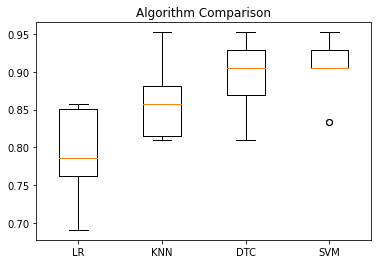

In [99]:
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

###Make Prediction and Evaluate them

In [100]:
Y_knn = knn.predict(X_test_rfe) 
Y_dtc = dtc.predict(X_test_rfe) 
Y_svm = svm.predict(X_test_rfe) 
Y_lr = LR.predict(X_test_rfe) 


print('Accuracy KNN: %.2f' % (accuracy_score(Y_test, Y_knn)*100))
print('Accuracy DT: %.2f' % (accuracy_score(Y_test, Y_dtc)*100))
print('Accuracy SVM: %.2f' % (accuracy_score(Y_test, Y_svm)*100))
print('Accuracy LR: %.2f' % (accuracy_score(Y_test, Y_lr)*100))

print(confusion_matrix(Y_test, Y_knn))
print(classification_report(Y_test, Y_svm))



Accuracy KNN: 79.49
Accuracy DT: 66.67
Accuracy SVM: 79.49
Accuracy LR: 75.64
[[ 8  7]
 [ 9 54]]
              precision    recall  f1-score   support

         0.0       0.40      0.13      0.20        15
         1.0       0.82      0.95      0.88        63

    accuracy                           0.79        78
   macro avg       0.61      0.54      0.54        78
weighted avg       0.74      0.79      0.75        78



In [101]:
print('f1_Accuracy KNN: %.2f' % (f1_score(Y_test, Y_knn,  average=None)[0]*100),(f1_score(Y_test, Y_knn,  average=None)[1]*100))
print('f1_Accuracy DT: %.2f' % (f1_score(Y_test, Y_dtc, average=None)[0]*100), (f1_score(Y_test, Y_dtc, average=None)[1]*100))
print('f1_Accuracy SVM: %.2f' % (f1_score(Y_test, Y_svm, average=None)[0]*100), f1_score(Y_test, Y_svm, average=None)[1]*100)
print('f1_Accuracy LR: %.2f' % (f1_score(Y_test, Y_lr, average=None)[0]*100), f1_score(Y_test, Y_lr, average=None)[1]*100)

f1_Accuracy KNN: 50.00 87.09677419354838
f1_Accuracy DT: 18.75 79.03225806451613
f1_Accuracy SVM: 20.00 88.23529411764706
f1_Accuracy LR: 59.57 82.56880733944955


In [102]:
print('auc_Accuracy KNN: %.2f' % (roc_auc_score(Y_test, Y_knn,  average=None)*100))
print('auc_Accuracy DT: %.2f' % (roc_auc_score(Y_test, Y_dtc, average=None)*100))
print('auc_Accuracy SVM: %.2f' % (roc_auc_score(Y_test, Y_svm, average=None)*100))
print('auc_Accuracy LR: %.2f' % (roc_auc_score(Y_test, Y_lr, average=None)*100))

auc_Accuracy KNN: 69.52
auc_Accuracy DT: 48.89
auc_Accuracy SVM: 54.29
auc_Accuracy LR: 82.38


In [103]:
print('mean_squared_error KNN: %.2f' % (met.mean_squared_error(Y_test, Y_knn)))
print('mean_squared_error DT: %.2f' % (met.mean_squared_error(Y_test, Y_dtc)))
print('mean_squared_error SVM: %.2f' % (met.mean_squared_error(Y_test, Y_svm)))
print('mean_squared_error LR: %.2f' % (met.mean_squared_error(Y_test, Y_lr)))

mean_squared_error KNN: 0.21
mean_squared_error DT: 0.33
mean_squared_error SVM: 0.21
mean_squared_error LR: 0.24


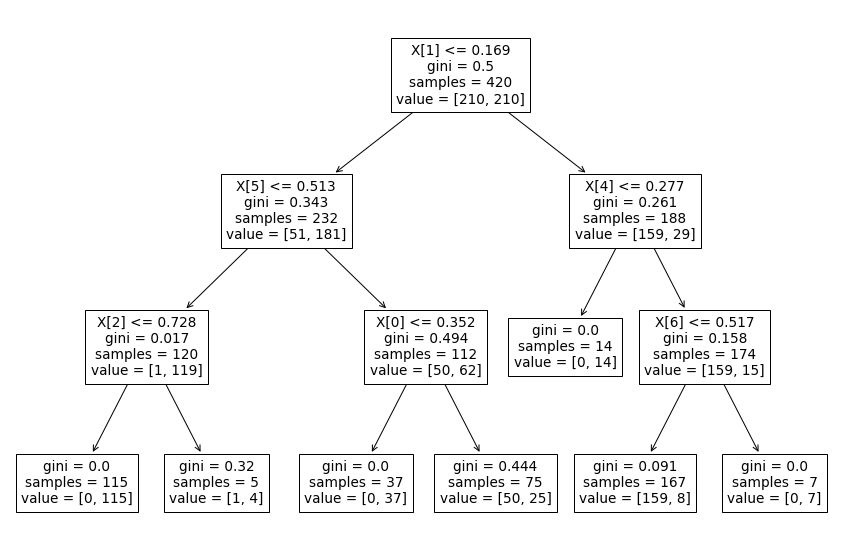

In [104]:
plt.figure(figsize=(15,10))
tree.plot_tree(dtc)
plt.show()

###Feature Extraction with PCA

In [105]:
pca = PCA(n_components=14)
principalComponents = pca.fit_transform(x_train.loc[:, x_train.columns != 'diabetes'])
principalDf = pd.DataFrame(data = principalComponents)
print(pca.explained_variance_ratio_)

[6.02613939e-01 1.24617053e-01 1.05318690e-01 5.49514629e-02
 3.15766237e-02 2.66947606e-02 2.22895428e-02 1.36680509e-02
 8.35305187e-03 5.58792291e-03 3.65006822e-03 4.70161283e-04
 1.63082762e-04 4.55910735e-05]


In [106]:
pca = PCA(n_components=7)
principalComponents = pca.fit_transform(x_train.loc[:, x_train.columns != 'diabetes'])
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc 1', 'pc 2','pc 3','pc 4','pc 5','pc 6', 'pc 7'])

In [108]:
pca2 = PCA(n_components=7)
principalComponents2 = pca2.fit_transform(X_test)
principalDf2 = pd.DataFrame(data = principalComponents2, columns = ['pc 1', 'pc 2','pc 3','pc 4','pc 5', 'pc 6', 'pc 7'])

In [109]:
x_train=principalDf
x_train['diabetes']=y_resampled.tolist()
x_test=principalDf2

In [110]:
# KNN
from sklearn.neighbors import KNeighborsClassifier 
 
knn = KNeighborsClassifier(n_neighbors=4, metric='minkowski', p=2) 
knn.fit(x_train.loc[:, x_train.columns != 'diabetes'], x_train['diabetes']) 


# Decision Tree
from sklearn.tree import DecisionTreeClassifier 
dtc = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=3, min_samples_leaf=5) 
dtc = dtc.fit(x_train.loc[:, x_train.columns != 'diabetes'], x_train['diabetes']) 


# SVM
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf')
svm = svm.fit(x_train.loc[:, x_train.columns != 'diabetes'], x_train['diabetes']) 


# Logestic regression
LR = LogisticRegression(solver='liblinear')
LR = LR.fit(x_train.loc[:, x_train.columns != 'diabetes'], x_train['diabetes'])


###Select Best Model

In [111]:
models = []
models.append(('LR', LR))
models.append(('KNN', knn))
models.append(('DTC', dtc))
models.append(('SVM', svm))
print(models)

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, x_train.loc[:, x_train.columns != 'diabetes'], x_train['diabetes'], cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


[('LR', LogisticRegression(solver='liblinear')), ('KNN', KNeighborsClassifier(n_neighbors=4)), ('DTC', DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)), ('SVM', SVC())]
LR: 0.823810 (0.064065)
KNN: 0.847619 (0.047857)
DTC: 0.823810 (0.071587)
SVM: 0.911905 (0.054346)


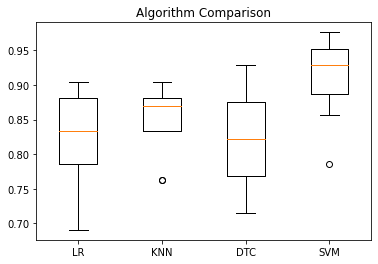

In [112]:
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

###Make Prediction and Evaluate them


In [113]:
Y_knn = knn.predict(x_test) 
Y_dtc = dtc.predict(x_test) 
Y_svm = svm.predict(x_test) 
Y_lr = LR.predict(x_test) 


print('Accuracy KNN: %.2f' % (accuracy_score(Y_test, Y_knn)*100))
print('Accuracy DT: %.2f' % (accuracy_score(Y_test, Y_dtc)*100))
print('Accuracy SVM: %.2f' % (accuracy_score(Y_test, Y_svm)*100))
print('Accuracy LR: %.2f' % (accuracy_score(Y_test, Y_lr)*100))

print(confusion_matrix(Y_test, Y_knn))
print(classification_report(Y_test, Y_svm))



Accuracy KNN: 44.87
Accuracy DT: 43.59
Accuracy SVM: 56.41
Accuracy LR: 30.77
[[ 2 13]
 [30 33]]
              precision    recall  f1-score   support

         0.0       0.05      0.07      0.06        15
         1.0       0.75      0.68      0.72        63

    accuracy                           0.56        78
   macro avg       0.40      0.37      0.39        78
weighted avg       0.62      0.56      0.59        78



In [114]:
print('f1_Accuracy KNN: %.2f' % (f1_score(Y_test, Y_knn,  average=None)[0]*100),(f1_score(Y_test, Y_knn,  average=None)[1]*100))
print('f1_Accuracy DT: %.2f' % (f1_score(Y_test, Y_dtc, average=None)[0]*100), (f1_score(Y_test, Y_dtc, average=None)[1]*100))
print('f1_Accuracy SVM: %.2f' % (f1_score(Y_test, Y_svm, average=None)[0]*100), f1_score(Y_test, Y_svm, average=None)[1]*100)
print('f1_Accuracy LR: %.2f' % (f1_score(Y_test, Y_lr, average=None)[0]*100), f1_score(Y_test, Y_lr, average=None)[1]*100)

f1_Accuracy KNN: 8.51 60.550458715596335
f1_Accuracy DT: 12.00 58.49056603773584
f1_Accuracy SVM: 5.56 71.66666666666669
f1_Accuracy LR: 3.57 46.0


In [115]:
print('auc_Accuracy KNN: %.2f' % (roc_auc_score(Y_test, Y_knn,  average=None)*100))
print('auc_Accuracy DT: %.2f' % (roc_auc_score(Y_test, Y_dtc, average=None)*100))
print('auc_Accuracy SVM: %.2f' % (roc_auc_score(Y_test, Y_svm, average=None)*100))
print('auc_Accuracy LR: %.2f' % (roc_auc_score(Y_test, Y_lr, average=None)*100))

auc_Accuracy KNN: 32.86
auc_Accuracy DT: 34.60
auc_Accuracy SVM: 37.46
auc_Accuracy LR: 21.59


In [116]:
print('mean_squared_error KNN: %.2f' % (met.mean_squared_error(Y_test, Y_knn)))
print('mean_squared_error DT: %.2f' % (met.mean_squared_error(Y_test, Y_dtc)))
print('mean_squared_error SVM: %.2f' % (met.mean_squared_error(Y_test, Y_svm)))
print('mean_squared_error LR: %.2f' % (met.mean_squared_error(Y_test, Y_lr)))

mean_squared_error KNN: 0.55
mean_squared_error DT: 0.56
mean_squared_error SVM: 0.44
mean_squared_error LR: 0.69


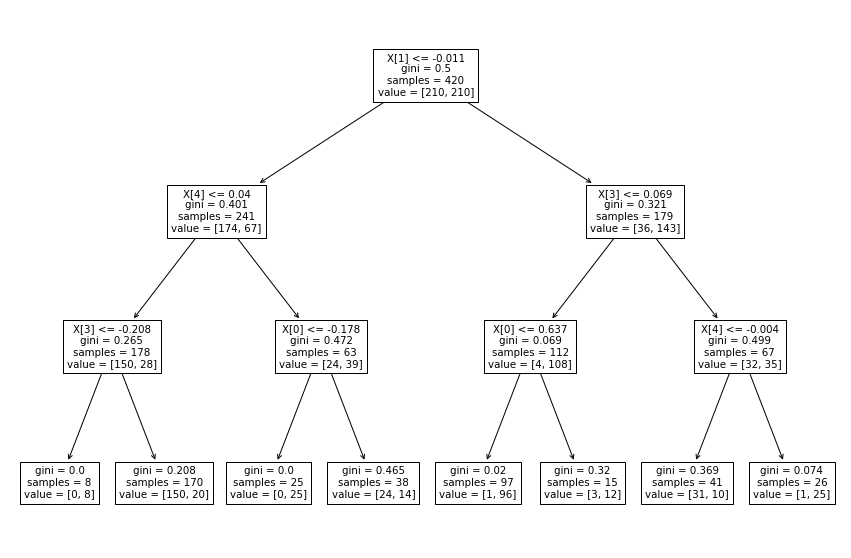

In [117]:
plt.figure(figsize=(15,10))
tree.plot_tree(dtc)
plt.show()